# 09 - Final Evaluation and Deployment Prepartion

## 9.1 Set-up

### 9.1.1 Initial Config

In [11]:
# logger.info("Setting up root by appending the parent to the sys...")
from jupyter_init import setup

setup()

from src_code.config import *

### 9.1.2 Logger

In [12]:
from notebooks.logging_config import setup_notebook_logging

logger, log_start, log_check, log_result = setup_notebook_logging(label="ENGINEERING")

log_start(print_to_console=True)
log_result("Logging configured.", print_to_console=True)

================== Starting notebook: 09-final-eval-and-deploy-prep (Session 833) ==================
[ENGINEERING RESULT] Logging configured.


### 9.1.3 Imports

In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib

### 9.1.4 Loading Testing Dataset

In [14]:
log_check("Loading the dataset...")

# TRANSFORMED_DF = EXTRACTED_DATA_DIR / "train_labeled_features_partial.feather"
# DF_PATH = ENGINEERING_MAPPINGS['test']['output']
DF_PATH = 'lala.feather'

# ---- LOAD ----
df = pd.read_feather(DF_PATH)
df.describe()

[ENGINEERING CHECK] Loading the dataset...


,msg_emb_0,loc_deleted_x_hunks_count,max_func_change,msg_len,msg_emb_3,code_emb_7,loc_churn_ratio,ast_delta,author_recent_activity_pre,loc_added_x_hunks_count,...,msg_emb_28,msg_emb_2,todo_ratio,msg_emb_15,time_since_last_change,msg_emb_12,msg_emb_16,msg_emb_5,msg_emb_42,label
count,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,...,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000,7363.000000
mean,-0.594244,14.801155,3.994454,4.857223,-0.175988,-0.031203,0.662657,2.704583,2.444520,12.927895,...,-0.006119,-0.034018,0.015466,-0.037015,7.002572,0.071205,0.014369,-0.041744,-0.016125,0.112454
std,1.464456,8.877840,1.485577,0.764812,0.786018,0.425838,0.382928,2.298529,1.339029,9.184485,...,0.189303,0.952882,0.056913,0.307945,1.865929,0.341359,0.268836,0.670259,0.157712,0.315946
min,-7.478381,0.000000,0.000000,2.833213,-1.738626,-2.879013,0.000000,0.000000,0.000000,0.000000,...,-1.280628,-1.801962,0.000000,-1.093458,0.000000,-1.437500,-1.306348,-1.977088,-0.753218,0.000000
25%,-1.427278,7.672484,3.583519,4.174387,-0.774948,-0.337676,0.490140,0.000000,1.609438,4.569000,...,-0.127033,-0.679793,0.000000,-0.232241,6.003887,-0.113268,-0.168067,-0.499725,-0.114736,0.000000
50%,-0.286168,14.257489,4.276666,4.859812,-0.290324,-0.080064,0.699942,3.091042,2.564949,11.970531,...,-0.005375,-0.103496,0.000000,-0.040374,7.199678,0.080430,0.012876,-0.052648,-0.018305,0.000000
75%,0.493243,21.604479,5.023881,5.517453,0.354430,0.262353,0.798121,5.075174,3.367296,20.289937,...,0.119078,0.379371,0.000000,0.138391,8.362409,0.297754,0.203845,0.448016,0.087532,0.000000
max,3.287601,30.256774,5.592851,5.985195,2.399244,1.273899,5.164786,5.474369,5.081404,28.277126,...,0.748266,4.972027,0.616776,1.168530,9.702105,1.032954,1.014114,2.171521,0.578418,1.000000


### 9.1.5 Loading Trained Model

In [15]:
MODEL_PATH = RANDOM_FOREST_MODEL
model = joblib.load(MODEL_PATH)
rf = model.named_steps['rf']
print("Pipeline Steps:", model.named_steps.keys())
log_result(f"Hyperparameters: {rf.get_params()}")
features = model.named_steps["rf"].feature_names_in_
print(f"The model was trained on {len(features)} features:")
print(features)

Pipeline Steps: dict_keys(['rf'])
[ENGINEERING RESULT] Hyperparameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 20, 'max_features': 'log2', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 300, 'n_jobs': 1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
The model was trained on 70 features:
['msg_emb_0' 'loc_deleted_x_hunks_count' 'max_func_change' 'msg_len'
 'msg_emb_3' 'code_emb_7' 'loc_churn_ratio' 'ast_delta'
 'author_recent_activity_pre' 'loc_added_x_hunks_count' 'msg_emb_14'
 'code_emb_1' 'line_token_total' 'code_emb_2' 'recent_churn' 'msg_emb_8'
 'msg_emb_4' 'msg_emb_35' 'loc_added_x_loc_deleted' 'msg_emb_29'
 'msg_emb_26' 'msg_emb_21' 'msg_emb_7' 'msg_emb_33' 'msg_emb_6'
 'code_emb_9' 'hunks_count' 'code_emb_5' 'msg_emb_22' 'code_emb_6'
 'complexity_delta

## 9.2 Final Evaluation

### 9.2.1 Inference

In [16]:
# 5. Prepare Features for Prediction
# Ensure you drop non-feature columns (labels, commits, hashes) before predicting
# Replace 'label' with your actual target column name
X_test = df.drop(
    columns=[
        "label",
        "commit",
        "datetime",
        "repo",
        "author_email",
        "canonical_datetime",
        "content",
        "filepath",
        "files_changed",
        'lines',
        'loc_added_bucket',
        "methods"
    ],
    errors="ignore",
)
y_true = df["label"] if "label" in df.columns else None
print(y_true)
# # 6. Predict
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]  # Probability of the positive class

0       1
1       0
2       0
3       0
4       0
       ..
7358    0
7359    0
7360    0
7361    0
7362    0
Name: label, Length: 7363, dtype: int64


### 9.2.2 Evaluation

In [17]:
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

if y_true is not None:
    print(classification_report(y_true, predictions))
    print(f"ROC-AUC Score: {roc_auc_score(y_true, probabilities):.4f}")

              precision    recall  f1-score   support

           0       0.96      0.38      0.54      6535
           1       0.15      0.87      0.26       828

    accuracy                           0.43      7363
   macro avg       0.55      0.62      0.40      7363
weighted avg       0.87      0.43      0.51      7363

ROC-AUC Score: 0.6533


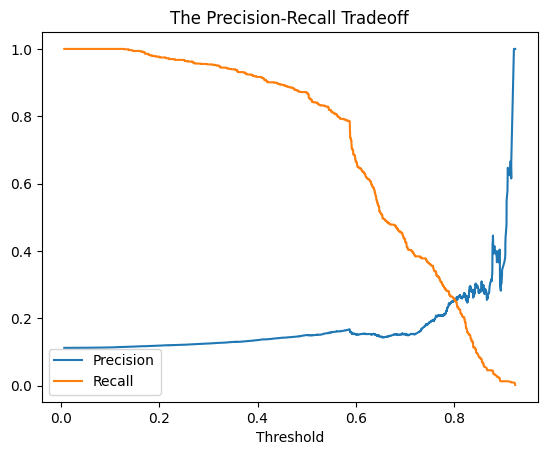

In [18]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Get probabilities instead of hard predictions
probs = model.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_true, probs)

plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.title("The Precision-Recall Tradeoff")
plt.legend()
plt.show()

In [19]:
# Instead of predictions = model.predict(X_test)
custom_threshold = 0.75  # Found from the chart above
custom_predictions = (probs >= custom_threshold).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_true, custom_predictions))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85      6535
           1       0.19      0.36      0.25       828

    accuracy                           0.75      7363
   macro avg       0.55      0.58      0.55      7363
weighted avg       0.83      0.75      0.78      7363



In [20]:
from sklearn.metrics import f1_score
import numpy as np

# Calculate F1 for every threshold produced by the PR curve
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]

print(f"Optimal Threshold for F1: {best_threshold:.4f}")
print(f"Best achievable F1-Score: {f1_scores[best_idx]:.4f}")

# Apply this threshold
final_preds = (probs >= best_threshold).astype(int)
print(classification_report(y_true, final_preds))

Optimal Threshold for F1: 0.5866
Best achievable F1-Score: 0.2761
              precision    recall  f1-score   support

           0       0.95      0.50      0.66      6535
           1       0.17      0.79      0.28       828

    accuracy                           0.54      7363
   macro avg       0.56      0.65      0.47      7363
weighted avg       0.86      0.54      0.62      7363



In [21]:
# import pandas as pd

# # Get feature names from the preprocessor we fixed earlier
# feature_names = preprocessor.get_feature_names_out()
# importances = model.feature_importances_

# feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
# print("Top 10 Most Important Features:")
# print(feat_imp.head(10))

In [22]:
from sklearn.metrics import matthews_corrcoef
import numpy as np

# 1. Get the probabilities
probs = model.predict_proba(X_test)[:, 1]

# 2. Test 100 different thresholds to find the best MCC
thresholds = np.linspace(0, 1, 100)
mcc_scores = [matthews_corrcoef(y_true, probs >= t) for t in thresholds]

# 3. Find the best one
best_threshold = thresholds[np.argmax(mcc_scores)]
best_mcc = max(mcc_scores)

print(f"Optimal Threshold for MCC: {best_threshold:.4f}")
print(f"Best MCC Score: {best_mcc:.4f}")

# 4. Generate the final report
final_predictions = (probs >= best_threshold).astype(int)
print(classification_report(y_true, final_predictions))

Optimal Threshold for MCC: 0.5859
Best MCC Score: 0.1825
              precision    recall  f1-score   support

           0       0.95      0.50      0.66      6535
           1       0.17      0.79      0.28       828

    accuracy                           0.53      7363
   macro avg       0.56      0.64      0.47      7363
weighted avg       0.86      0.53      0.61      7363



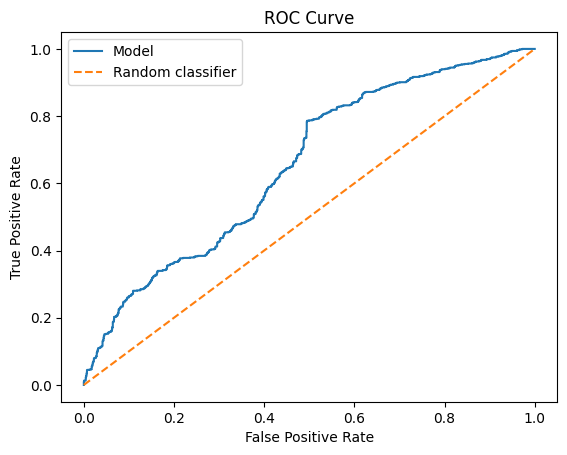

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(y_true, probs)

plt.plot(fpr, tpr, label="Model")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random classifier")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
